In [13]:
import keras
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Reshape,Conv2DTranspose,Input,Activation,BatchNormalization
from keras.optimizers import Adam,SGD
#packages to plot models
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

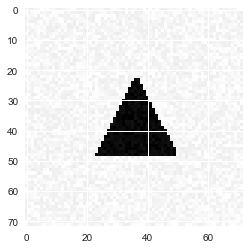

In [433]:
# %load mp1.py
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




# Simple classification

In [22]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


1.0


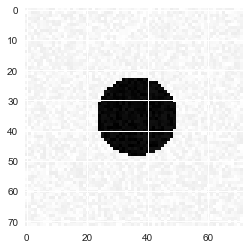

In [42]:
plt.imshow(X_train[7].reshape(72,72), cmap='gray')
print(Y_train[7])

2.0


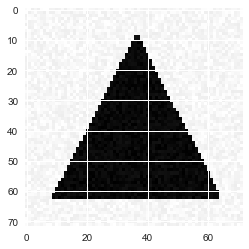

In [44]:
plt.imshow(X_train[6].reshape(72,72), cmap='gray')
print(Y_train[6])

0.0


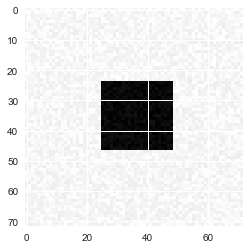

In [45]:
plt.imshow(X_train[8].reshape(72,72), cmap='gray')
print(Y_train[8])

In [168]:
Y_train=np_utils.to_categorical(Y_train,num_classes=3)

In [51]:
Y_train.shape

(300, 3)

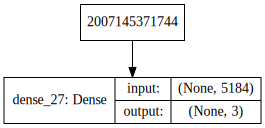

In [165]:
#Model
model=Sequential()
model.add(Dense(3,activation='softmax',input_dim=X_train.shape[1]))

model.compile(optimizer=SGD(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [166]:
model.fit(X_train,Y_train,epochs=300)

Epoch 1/300
300/300 [==============================] - 1s 4ms/step - loss: 1.1745 - acc: 0.4000
Epoch 2/300
300/300 [==============================] - 0s 159us/step - loss: 0.9848 - acc: 0.5367
Epoch 3/300
300/300 [==============================] - 0s 168us/step - loss: 0.8920 - acc: 0.6367
Epoch 4/300
300/300 [==============================] - 0s 167us/step - loss: 0.8128 - acc: 0.6667
Epoch 5/300
300/300 [==============================] - 0s 160us/step - loss: 0.7913 - acc: 0.6667
Epoch 6/300
300/300 [==============================] - 0s 171us/step - loss: 0.7338 - acc: 0.7300
Epoch 7/300
300/300 [==============================] - 0s 155us/step - loss: 0.6780 - acc: 0.7200
Epoch 8/300
300/300 [==============================] - 0s 173us/step - loss: 0.6762 - acc: 0.7100
Epoch 9/300
300/300 [==============================] - 0s 164us/step - loss: 0.6312 - acc: 0.7767
Epoch 10/300
300/300 [==============================] - 0s 173us/step - loss: 0.5947 - acc: 0.8400
Epoch 11/300
300/300 

300/300 [==============================] - 0s 163us/step - loss: 0.1324 - acc: 0.9900
Epoch 166/300
300/300 [==============================] - 0s 165us/step - loss: 0.1301 - acc: 0.9933
Epoch 167/300
300/300 [==============================] - 0s 160us/step - loss: 0.1307 - acc: 0.9900
Epoch 168/300
300/300 [==============================] - 0s 160us/step - loss: 0.1329 - acc: 0.9800
Epoch 169/300
300/300 [==============================] - 0s 146us/step - loss: 0.1306 - acc: 0.9867
Epoch 170/300
300/300 [==============================] - 0s 160us/step - loss: 0.1321 - acc: 0.9833
Epoch 171/300
300/300 [==============================] - 0s 156us/step - loss: 0.1295 - acc: 0.9900
Epoch 172/300
300/300 [==============================] - 0s 154us/step - loss: 0.1271 - acc: 0.9900
Epoch 173/300
300/300 [==============================] - 0s 150us/step - loss: 0.1269 - acc: 0.9933
Epoch 174/300
300/300 [==============================] - 0s 162us/step - loss: 0.1266 - acc: 0.9900
Epoch 175/300


300/300 [==============================] - 0s 213us/step - loss: 0.0988 - acc: 0.9900
Epoch 248/300
300/300 [==============================] - 0s 166us/step - loss: 0.0961 - acc: 0.9867
Epoch 249/300
300/300 [==============================] - 0s 175us/step - loss: 0.0978 - acc: 0.9933
Epoch 250/300
300/300 [==============================] - 0s 184us/step - loss: 0.0983 - acc: 0.9867
Epoch 251/300
300/300 [==============================] - 0s 173us/step - loss: 0.0989 - acc: 0.9900
Epoch 252/300
300/300 [==============================] - 0s 141us/step - loss: 0.0938 - acc: 0.9933
Epoch 253/300
300/300 [==============================] - 0s 150us/step - loss: 0.0950 - acc: 0.9933
Epoch 254/300
300/300 [==============================] - 0s 160us/step - loss: 0.0949 - acc: 0.9967
Epoch 255/300
300/300 [==============================] - 0s 158us/step - loss: 0.0955 - acc: 0.9867
Epoch 256/300
300/300 [==============================] - 0s 163us/step - loss: 0.0949 - acc: 0.9900
Epoch 257/300


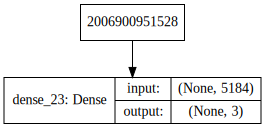

In [140]:
#Model
model=Sequential()
model.add(Dense(3,activation='softmax',input_dim=X_train.shape[1]))

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [142]:
model.fit(X_train,Y_train,epochs=1000,batch_size=32)

Epoch 1/1000
300/300 [==============================] - 0s 150us/step - loss: 0.5149 - acc: 0.8867
Epoch 2/1000
300/300 [==============================] - 0s 182us/step - loss: 0.5124 - acc: 0.8933
Epoch 3/1000
300/300 [==============================] - 0s 140us/step - loss: 0.5088 - acc: 0.9000
Epoch 4/1000
300/300 [==============================] - 0s 158us/step - loss: 0.5061 - acc: 0.9100
Epoch 5/1000
300/300 [==============================] - 0s 157us/step - loss: 0.5036 - acc: 0.8933
Epoch 6/1000
300/300 [==============================] - 0s 163us/step - loss: 0.5010 - acc: 0.8933
Epoch 7/1000
300/300 [==============================] - 0s 171us/step - loss: 0.4977 - acc: 0.8967
Epoch 8/1000
300/300 [==============================] - 0s 159us/step - loss: 0.4960 - acc: 0.9067
Epoch 9/1000
300/300 [==============================] - 0s 153us/step - loss: 0.4952 - acc: 0.9167
Epoch 10/1000
300/300 [==============================] - 0s 166us/step - loss: 0.4906 - acc: 0.9167
Epoch 11/

300/300 [==============================] - 0s 160us/step - loss: 0.3589 - acc: 0.9833
Epoch 84/1000
300/300 [==============================] - 0s 159us/step - loss: 0.3579 - acc: 0.9800
Epoch 85/1000
300/300 [==============================] - 0s 154us/step - loss: 0.3575 - acc: 0.9767
Epoch 86/1000
300/300 [==============================] - 0s 136us/step - loss: 0.3549 - acc: 0.9800
Epoch 87/1000
300/300 [==============================] - 0s 145us/step - loss: 0.3534 - acc: 0.9833
Epoch 88/1000
300/300 [==============================] - 0s 140us/step - loss: 0.3522 - acc: 0.9833
Epoch 89/1000
300/300 [==============================] - 0s 135us/step - loss: 0.3510 - acc: 0.9733
Epoch 90/1000
300/300 [==============================] - 0s 126us/step - loss: 0.3503 - acc: 0.9733
Epoch 91/1000
300/300 [==============================] - 0s 133us/step - loss: 0.3489 - acc: 0.9667
Epoch 92/1000
300/300 [==============================] - 0s 145us/step - loss: 0.3473 - acc: 0.9767
Epoch 93/1000


300/300 [==============================] - 0s 170us/step - loss: 0.2159 - acc: 0.9900
Epoch 246/1000
300/300 [==============================] - 0s 160us/step - loss: 0.2153 - acc: 0.9900
Epoch 247/1000
300/300 [==============================] - 0s 157us/step - loss: 0.2150 - acc: 0.9900
Epoch 248/1000
300/300 [==============================] - 0s 149us/step - loss: 0.2142 - acc: 0.9900
Epoch 249/1000
300/300 [==============================] - 0s 140us/step - loss: 0.2136 - acc: 0.9900
Epoch 250/1000
300/300 [==============================] - 0s 161us/step - loss: 0.2129 - acc: 0.9900
Epoch 251/1000
300/300 [==============================] - 0s 150us/step - loss: 0.2122 - acc: 0.9900
Epoch 252/1000
300/300 [==============================] - 0s 167us/step - loss: 0.2118 - acc: 0.9867
Epoch 253/1000
300/300 [==============================] - 0s 156us/step - loss: 0.2113 - acc: 0.9900
Epoch 254/1000
300/300 [==============================] - 0s 160us/step - loss: 0.2107 - acc: 0.9900
Epoch

300/300 [==============================] - 0s 162us/step - loss: 0.1432 - acc: 0.9900
Epoch 408/1000
300/300 [==============================] - 0s 153us/step - loss: 0.1431 - acc: 0.9900
Epoch 409/1000
300/300 [==============================] - 0s 160us/step - loss: 0.1427 - acc: 0.9900
Epoch 410/1000
300/300 [==============================] - 0s 166us/step - loss: 0.1423 - acc: 0.9900
Epoch 411/1000
300/300 [==============================] - 0s 160us/step - loss: 0.1420 - acc: 0.9900
Epoch 412/1000
300/300 [==============================] - 0s 165us/step - loss: 0.1417 - acc: 0.9900
Epoch 413/1000
300/300 [==============================] - 0s 164us/step - loss: 0.1413 - acc: 0.9900
Epoch 414/1000
300/300 [==============================] - 0s 160us/step - loss: 0.1414 - acc: 0.9933
Epoch 415/1000
300/300 [==============================] - 0s 153us/step - loss: 0.1408 - acc: 0.9900
Epoch 416/1000
300/300 [==============================] - 0s 150us/step - loss: 0.1409 - acc: 0.9900
Epoch

300/300 [==============================] - 0s 154us/step - loss: 0.1006 - acc: 0.9967
Epoch 570/1000
300/300 [==============================] - 0s 173us/step - loss: 0.1004 - acc: 0.9967
Epoch 571/1000
300/300 [==============================] - 0s 170us/step - loss: 0.1002 - acc: 0.9967
Epoch 572/1000
300/300 [==============================] - 0s 160us/step - loss: 0.0997 - acc: 0.9967
Epoch 573/1000
300/300 [==============================] - 0s 168us/step - loss: 0.0997 - acc: 1.0000
Epoch 574/1000
300/300 [==============================] - 0s 165us/step - loss: 0.0992 - acc: 0.9967
Epoch 575/1000
300/300 [==============================] - 0s 151us/step - loss: 0.0993 - acc: 0.9967
Epoch 576/1000
300/300 [==============================] - 0s 146us/step - loss: 0.0992 - acc: 1.0000
Epoch 577/1000
300/300 [==============================] - 0s 153us/step - loss: 0.0988 - acc: 1.0000
Epoch 578/1000
300/300 [==============================] - 0s 153us/step - loss: 0.0986 - acc: 0.9967
Epoch

300/300 [==============================] - 0s 156us/step - loss: 0.0729 - acc: 1.0000
Epoch 731/1000
300/300 [==============================] - 0s 163us/step - loss: 0.0728 - acc: 1.0000
Epoch 732/1000
300/300 [==============================] - 0s 152us/step - loss: 0.0728 - acc: 1.0000
Epoch 733/1000
300/300 [==============================] - 0s 151us/step - loss: 0.0725 - acc: 1.0000
Epoch 734/1000
300/300 [==============================] - 0s 143us/step - loss: 0.0724 - acc: 1.0000
Epoch 735/1000
300/300 [==============================] - 0s 171us/step - loss: 0.0723 - acc: 1.0000
Epoch 736/1000
300/300 [==============================] - 0s 155us/step - loss: 0.0719 - acc: 1.0000
Epoch 737/1000
300/300 [==============================] - 0s 153us/step - loss: 0.0720 - acc: 1.0000
Epoch 738/1000
300/300 [==============================] - 0s 159us/step - loss: 0.0716 - acc: 1.0000
Epoch 739/1000
300/300 [==============================] - 0s 152us/step - loss: 0.0718 - acc: 1.0000
Epoch

300/300 [==============================] - 0s 160us/step - loss: 0.0542 - acc: 1.0000
Epoch 892/1000
300/300 [==============================] - 0s 157us/step - loss: 0.0541 - acc: 1.0000
Epoch 893/1000
300/300 [==============================] - 0s 170us/step - loss: 0.0540 - acc: 1.0000
Epoch 894/1000
300/300 [==============================] - 0s 170us/step - loss: 0.0541 - acc: 1.0000
Epoch 895/1000
300/300 [==============================] - 0s 163us/step - loss: 0.0544 - acc: 1.0000
Epoch 896/1000
300/300 [==============================] - 0s 156us/step - loss: 0.0537 - acc: 1.0000
Epoch 897/1000
300/300 [==============================] - 0s 153us/step - loss: 0.0537 - acc: 1.0000
Epoch 898/1000
300/300 [==============================] - 0s 160us/step - loss: 0.0536 - acc: 1.0000
Epoch 899/1000
300/300 [==============================] - 0s 172us/step - loss: 0.0534 - acc: 1.0000
Epoch 900/1000
300/300 [==============================] - 0s 160us/step - loss: 0.0535 - acc: 1.0000
Epoch

In [156]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

<div class="alert alert-info">
Class 2 = 1 which is a disk (what we generated)
</div>

# Visualization of the Solution

In [145]:
weights=model.get_weights()

In [152]:
np.shape(weights[0][:,0])

(5184,)

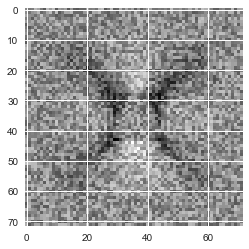

In [153]:
plt.imshow(weights[0][:,0].reshape(72,72), cmap='gray')


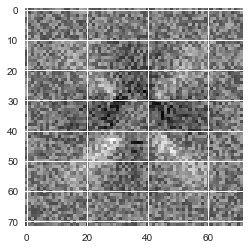

In [154]:
plt.imshow(weights[0][:,1].reshape(72,72), cmap='gray')


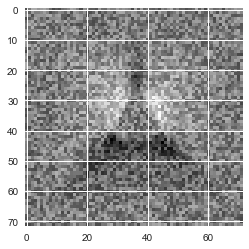

In [155]:
plt.imshow(weights[0][:,2].reshape(72,72), cmap='gray')


<div class="alert alert-info">
We can see a rectangle, disk and a triangle in the corresponding column of the weight matrix (0: rectangle, 1:disk, 2:triangle).
</div>

# A More Difficult Classification Problem

In [170]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train=np_utils.to_categorical(Y_train,num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [173]:
#Model
model=Sequential()
model.add(Dense(3,activation='softmax',input_dim=X_train.shape[1]))

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
model.fit(X_train,Y_train,epochs=3000,batch_size=32)

Epoch 1/3000
300/300 [==============================] - 1s 4ms/step - loss: 2.3988 - acc: 0.3267
Epoch 2/3000
300/300 [==============================] - 0s 136us/step - loss: 1.9164 - acc: 0.3267
Epoch 3/3000
300/300 [==============================] - 0s 152us/step - loss: 1.5360 - acc: 0.3267
Epoch 4/3000
300/300 [==============================] - 0s 153us/step - loss: 1.2997 - acc: 0.3367
Epoch 5/3000
300/300 [==============================] - 0s 126us/step - loss: 1.1983 - acc: 0.3367
Epoch 6/3000
300/300 [==============================] - 0s 154us/step - loss: 1.1538 - acc: 0.2867
Epoch 7/3000
300/300 [==============================] - 0s 146us/step - loss: 1.1500 - acc: 0.2700
Epoch 8/3000
300/300 [==============================] - 0s 130us/step - loss: 1.1476 - acc: 0.2933
Epoch 9/3000
300/300 [==============================] - 0s 146us/step - loss: 1.1481 - acc: 0.3200
Epoch 10/3000
300/300 [==============================] - 0s 129us/step - loss: 1.1474 - acc: 0.2967
Epoch 11/30

300/300 [==============================] - 0s 148us/step - loss: 0.9821 - acc: 0.5133
Epoch 84/3000
300/300 [==============================] - 0s 126us/step - loss: 0.9812 - acc: 0.5167
Epoch 85/3000
300/300 [==============================] - 0s 141us/step - loss: 0.9796 - acc: 0.5167
Epoch 86/3000
300/300 [==============================] - 0s 154us/step - loss: 0.9787 - acc: 0.5133
Epoch 87/3000
300/300 [==============================] - 0s 156us/step - loss: 0.9759 - acc: 0.5200
Epoch 88/3000
300/300 [==============================] - 0s 125us/step - loss: 0.9778 - acc: 0.4933
Epoch 89/3000
300/300 [==============================] - 0s 143us/step - loss: 0.9751 - acc: 0.5100
Epoch 90/3000
300/300 [==============================] - 0s 130us/step - loss: 0.9732 - acc: 0.5067
Epoch 91/3000
300/300 [==============================] - 0s 126us/step - loss: 0.9757 - acc: 0.4900
Epoch 92/3000
300/300 [==============================] - 0s 145us/step - loss: 0.9723 - acc: 0.5067
Epoch 93/3000


C:\Users\dell\Anaconda3\envs\keras-py36\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103835). Check your callbacks.
  % delta_t_median)


300/300 [==============================] - 0s 200us/step - loss: 0.8428 - acc: 0.6400
Epoch 226/3000
300/300 [==============================] - 0s 194us/step - loss: 0.8417 - acc: 0.6400
Epoch 227/3000
300/300 [==============================] - 0s 162us/step - loss: 0.8417 - acc: 0.6300
Epoch 228/3000
300/300 [==============================] - 0s 153us/step - loss: 0.8409 - acc: 0.6400
Epoch 229/3000
300/300 [==============================] - 0s 171us/step - loss: 0.8399 - acc: 0.6433
Epoch 230/3000
300/300 [==============================] - 0s 237us/step - loss: 0.8387 - acc: 0.6367
Epoch 231/3000
300/300 [==============================] - 0s 207us/step - loss: 0.8386 - acc: 0.6233
Epoch 232/3000
300/300 [==============================] - 0s 258us/step - loss: 0.8384 - acc: 0.6367
Epoch 233/3000
300/300 [==============================] - 0s 144us/step - loss: 0.8392 - acc: 0.6233
Epoch 234/3000
300/300 [==============================] - 0s 188us/step - loss: 0.8361 - acc: 0.6367
Epoch

300/300 [==============================] - 0s 143us/step - loss: 0.7643 - acc: 0.6767
Epoch 386/3000
300/300 [==============================] - 0s 153us/step - loss: 0.7623 - acc: 0.6800
Epoch 387/3000
300/300 [==============================] - 0s 147us/step - loss: 0.7623 - acc: 0.7100
Epoch 388/3000
300/300 [==============================] - 0s 160us/step - loss: 0.7607 - acc: 0.7133
Epoch 389/3000
300/300 [==============================] - 0s 156us/step - loss: 0.7636 - acc: 0.6767
Epoch 390/3000
300/300 [==============================] - 0s 170us/step - loss: 0.7599 - acc: 0.6933
Epoch 391/3000
300/300 [==============================] - 0s 143us/step - loss: 0.7594 - acc: 0.7167
Epoch 392/3000
300/300 [==============================] - 0s 133us/step - loss: 0.7594 - acc: 0.7100
Epoch 393/3000
300/300 [==============================] - 0s 167us/step - loss: 0.7580 - acc: 0.6767
Epoch 394/3000
300/300 [==============================] - 0s 170us/step - loss: 0.7591 - acc: 0.6767
Epoch

300/300 [==============================] - 0s 175us/step - loss: 0.7081 - acc: 0.7333
Epoch 548/3000
300/300 [==============================] - 0s 179us/step - loss: 0.7093 - acc: 0.7300
Epoch 549/3000
300/300 [==============================] - 0s 169us/step - loss: 0.7080 - acc: 0.7200
Epoch 550/3000
300/300 [==============================] - 0s 190us/step - loss: 0.7087 - acc: 0.7167
Epoch 551/3000
300/300 [==============================] - 0s 173us/step - loss: 0.7075 - acc: 0.7233
Epoch 552/3000
300/300 [==============================] - 0s 150us/step - loss: 0.7072 - acc: 0.7300
Epoch 553/3000
300/300 [==============================] - 0s 145us/step - loss: 0.7079 - acc: 0.7000
Epoch 554/3000
300/300 [==============================] - 0s 167us/step - loss: 0.7054 - acc: 0.7167
Epoch 555/3000
300/300 [==============================] - 0s 177us/step - loss: 0.7079 - acc: 0.7267
Epoch 556/3000
300/300 [==============================] - 0s 178us/step - loss: 0.7064 - acc: 0.7367
Epoch

300/300 [==============================] - 0s 141us/step - loss: 0.6686 - acc: 0.7533
Epoch 709/3000
300/300 [==============================] - 0s 131us/step - loss: 0.6674 - acc: 0.7667
Epoch 710/3000
300/300 [==============================] - 0s 133us/step - loss: 0.6723 - acc: 0.7600
Epoch 711/3000
300/300 [==============================] - 0s 135us/step - loss: 0.6708 - acc: 0.7267
Epoch 712/3000
300/300 [==============================] - 0s 137us/step - loss: 0.6698 - acc: 0.7333
Epoch 713/3000
300/300 [==============================] - 0s 131us/step - loss: 0.6668 - acc: 0.7600
Epoch 714/3000
300/300 [==============================] - 0s 143us/step - loss: 0.6680 - acc: 0.7600
Epoch 715/3000
300/300 [==============================] - 0s 147us/step - loss: 0.6669 - acc: 0.7633
Epoch 716/3000
300/300 [==============================] - 0s 125us/step - loss: 0.6658 - acc: 0.7533
Epoch 717/3000
300/300 [==============================] - 0s 142us/step - loss: 0.6677 - acc: 0.7500
Epoch

300/300 [==============================] - 0s 161us/step - loss: 0.6366 - acc: 0.7833
Epoch 870/3000
300/300 [==============================] - 0s 165us/step - loss: 0.6359 - acc: 0.7733
Epoch 871/3000
300/300 [==============================] - 0s 140us/step - loss: 0.6329 - acc: 0.7800
Epoch 872/3000
300/300 [==============================] - 0s 153us/step - loss: 0.6343 - acc: 0.7500
Epoch 873/3000
300/300 [==============================] - 0s 151us/step - loss: 0.6344 - acc: 0.7667
Epoch 874/3000
300/300 [==============================] - 0s 141us/step - loss: 0.6337 - acc: 0.7800
Epoch 875/3000
300/300 [==============================] - 0s 131us/step - loss: 0.6337 - acc: 0.7800
Epoch 876/3000
300/300 [==============================] - 0s 148us/step - loss: 0.6332 - acc: 0.7800
Epoch 877/3000
300/300 [==============================] - 0s 186us/step - loss: 0.6332 - acc: 0.7700
Epoch 878/3000
300/300 [==============================] - 0s 216us/step - loss: 0.6325 - acc: 0.7767
Epoch

Epoch 1031/3000
300/300 [==============================] - 0s 143us/step - loss: 0.6055 - acc: 0.8167
Epoch 1032/3000
300/300 [==============================] - 0s 136us/step - loss: 0.6050 - acc: 0.8133
Epoch 1033/3000
300/300 [==============================] - 0s 147us/step - loss: 0.6063 - acc: 0.8033
Epoch 1034/3000
300/300 [==============================] - 0s 137us/step - loss: 0.6049 - acc: 0.8100
Epoch 1035/3000
300/300 [==============================] - 0s 123us/step - loss: 0.6052 - acc: 0.8100
Epoch 1036/3000
300/300 [==============================] - 0s 128us/step - loss: 0.6058 - acc: 0.7967
Epoch 1037/3000
300/300 [==============================] - 0s 135us/step - loss: 0.6049 - acc: 0.8167
Epoch 1038/3000
300/300 [==============================] - 0s 145us/step - loss: 0.6069 - acc: 0.8067
Epoch 1039/3000
300/300 [==============================] - 0s 134us/step - loss: 0.6035 - acc: 0.8133
Epoch 1040/3000
300/300 [==============================] - 0s 153us/step - loss: 0

300/300 [==============================] - 0s 121us/step - loss: 0.5830 - acc: 0.8067
Epoch 1192/3000
300/300 [==============================] - 0s 143us/step - loss: 0.5816 - acc: 0.8300
Epoch 1193/3000
300/300 [==============================] - 0s 138us/step - loss: 0.5798 - acc: 0.8233
Epoch 1194/3000
300/300 [==============================] - 0s 124us/step - loss: 0.5800 - acc: 0.8467
Epoch 1195/3000
300/300 [==============================] - 0s 135us/step - loss: 0.5802 - acc: 0.8267
Epoch 1196/3000
300/300 [==============================] - 0s 139us/step - loss: 0.5802 - acc: 0.8400
Epoch 1197/3000
300/300 [==============================] - 0s 129us/step - loss: 0.5808 - acc: 0.8167
Epoch 1198/3000
300/300 [==============================] - 0s 139us/step - loss: 0.5800 - acc: 0.8367
Epoch 1199/3000
300/300 [==============================] - 0s 153us/step - loss: 0.5815 - acc: 0.8167
Epoch 1200/3000
300/300 [==============================] - 0s 129us/step - loss: 0.5796 - acc: 0.8

300/300 [==============================] - 0s 149us/step - loss: 0.5583 - acc: 0.8533
Epoch 1352/3000
300/300 [==============================] - 0s 141us/step - loss: 0.5591 - acc: 0.8467
Epoch 1353/3000
300/300 [==============================] - 0s 126us/step - loss: 0.5586 - acc: 0.8400
Epoch 1354/3000
300/300 [==============================] - 0s 130us/step - loss: 0.5584 - acc: 0.8400
Epoch 1355/3000
300/300 [==============================] - 0s 152us/step - loss: 0.5573 - acc: 0.8367
Epoch 1356/3000
300/300 [==============================] - 0s 120us/step - loss: 0.5578 - acc: 0.8367
Epoch 1357/3000
300/300 [==============================] - 0s 125us/step - loss: 0.5583 - acc: 0.8133
Epoch 1358/3000
300/300 [==============================] - 0s 147us/step - loss: 0.5572 - acc: 0.8333
Epoch 1359/3000
300/300 [==============================] - 0s 143us/step - loss: 0.5566 - acc: 0.8467
Epoch 1360/3000
300/300 [==============================] - 0s 134us/step - loss: 0.5576 - acc: 0.8

300/300 [==============================] - 0s 168us/step - loss: 0.5383 - acc: 0.8633
Epoch 1512/3000
300/300 [==============================] - 0s 162us/step - loss: 0.5364 - acc: 0.8600
Epoch 1513/3000
300/300 [==============================] - 0s 138us/step - loss: 0.5380 - acc: 0.8433
Epoch 1514/3000
300/300 [==============================] - 0s 124us/step - loss: 0.5377 - acc: 0.8533
Epoch 1515/3000
300/300 [==============================] - 0s 134us/step - loss: 0.5373 - acc: 0.8667
Epoch 1516/3000
300/300 [==============================] - 0s 127us/step - loss: 0.5369 - acc: 0.8633
Epoch 1517/3000
300/300 [==============================] - 0s 155us/step - loss: 0.5368 - acc: 0.8467
Epoch 1518/3000
300/300 [==============================] - 0s 150us/step - loss: 0.5369 - acc: 0.8333
Epoch 1519/3000
300/300 [==============================] - 0s 151us/step - loss: 0.5363 - acc: 0.8533
Epoch 1520/3000
300/300 [==============================] - 0s 139us/step - loss: 0.5366 - acc: 0.8

300/300 [==============================] - 0s 149us/step - loss: 0.5187 - acc: 0.8633
Epoch 1672/3000
300/300 [==============================] - 0s 161us/step - loss: 0.5183 - acc: 0.8600
Epoch 1673/3000
300/300 [==============================] - 0s 140us/step - loss: 0.5179 - acc: 0.8600
Epoch 1674/3000
300/300 [==============================] - 0s 130us/step - loss: 0.5186 - acc: 0.8633
Epoch 1675/3000
300/300 [==============================] - 0s 137us/step - loss: 0.5191 - acc: 0.8567
Epoch 1676/3000
300/300 [==============================] - 0s 147us/step - loss: 0.5183 - acc: 0.8533
Epoch 1677/3000
300/300 [==============================] - 0s 135us/step - loss: 0.5167 - acc: 0.8667
Epoch 1678/3000
300/300 [==============================] - 0s 140us/step - loss: 0.5212 - acc: 0.8467
Epoch 1679/3000
300/300 [==============================] - 0s 154us/step - loss: 0.5183 - acc: 0.8567
Epoch 1680/3000
300/300 [==============================] - 0s 149us/step - loss: 0.5172 - acc: 0.8

300/300 [==============================] - 0s 133us/step - loss: 0.5010 - acc: 0.8667
Epoch 1832/3000
300/300 [==============================] - 0s 147us/step - loss: 0.5014 - acc: 0.8800
Epoch 1833/3000
300/300 [==============================] - 0s 129us/step - loss: 0.5014 - acc: 0.8667
Epoch 1834/3000
300/300 [==============================] - 0s 127us/step - loss: 0.5001 - acc: 0.8733
Epoch 1835/3000
300/300 [==============================] - 0s 142us/step - loss: 0.5009 - acc: 0.8633
Epoch 1836/3000
300/300 [==============================] - ETA: 0s - loss: 0.5172 - acc: 0.906 - 0s 133us/step - loss: 0.5014 - acc: 0.8733
Epoch 1837/3000
300/300 [==============================] - 0s 140us/step - loss: 0.4997 - acc: 0.8700
Epoch 1838/3000
300/300 [==============================] - 0s 151us/step - loss: 0.5012 - acc: 0.8600
Epoch 1839/3000
300/300 [==============================] - 0s 148us/step - loss: 0.5012 - acc: 0.8800
Epoch 1840/3000
300/300 [==============================] - 0

300/300 [==============================] - 0s 160us/step - loss: 0.4922 - acc: 0.8867
Epoch 1912/3000
300/300 [==============================] - 0s 156us/step - loss: 0.4930 - acc: 0.8800
Epoch 1913/3000
300/300 [==============================] - 0s 161us/step - loss: 0.4924 - acc: 0.8767
Epoch 1914/3000
300/300 [==============================] - 0s 163us/step - loss: 0.4922 - acc: 0.8833
Epoch 1915/3000
300/300 [==============================] - 0s 170us/step - loss: 0.4925 - acc: 0.8800
Epoch 1916/3000
300/300 [==============================] - 0s 186us/step - loss: 0.4919 - acc: 0.8867
Epoch 1917/3000
300/300 [==============================] - 0s 163us/step - loss: 0.4917 - acc: 0.8800
Epoch 1918/3000
300/300 [==============================] - 0s 167us/step - loss: 0.4932 - acc: 0.8700
Epoch 1919/3000
300/300 [==============================] - 0s 149us/step - loss: 0.4924 - acc: 0.8767
Epoch 1920/3000
300/300 [==============================] - 0s 144us/step - loss: 0.4915 - acc: 0.8

300/300 [==============================] - 0s 131us/step - loss: 0.4841 - acc: 0.8900
Epoch 1992/3000
300/300 [==============================] - 0s 141us/step - loss: 0.4847 - acc: 0.8900
Epoch 1993/3000
300/300 [==============================] - 0s 139us/step - loss: 0.4847 - acc: 0.8800
Epoch 1994/3000
300/300 [==============================] - 0s 126us/step - loss: 0.4841 - acc: 0.8833
Epoch 1995/3000
300/300 [==============================] - 0s 129us/step - loss: 0.4853 - acc: 0.8867
Epoch 1996/3000
300/300 [==============================] - 0s 127us/step - loss: 0.4845 - acc: 0.8833
Epoch 1997/3000
300/300 [==============================] - 0s 125us/step - loss: 0.4844 - acc: 0.8733
Epoch 1998/3000
300/300 [==============================] - 0s 119us/step - loss: 0.4840 - acc: 0.8800
Epoch 1999/3000
300/300 [==============================] - 0s 135us/step - loss: 0.4833 - acc: 0.8800
Epoch 2000/3000
300/300 [==============================] - 0s 148us/step - loss: 0.4840 - acc: 0.8

300/300 [==============================] - 0s 160us/step - loss: 0.4700 - acc: 0.8933
Epoch 2152/3000
300/300 [==============================] - 0s 155us/step - loss: 0.4695 - acc: 0.8933
Epoch 2153/3000
300/300 [==============================] - 0s 167us/step - loss: 0.4694 - acc: 0.8967
Epoch 2154/3000
300/300 [==============================] - 0s 156us/step - loss: 0.4687 - acc: 0.9033
Epoch 2155/3000
300/300 [==============================] - 0s 150us/step - loss: 0.4691 - acc: 0.8967
Epoch 2156/3000
300/300 [==============================] - 0s 149us/step - loss: 0.4697 - acc: 0.9067
Epoch 2157/3000
300/300 [==============================] - 0s 148us/step - loss: 0.4686 - acc: 0.9000
Epoch 2158/3000
300/300 [==============================] - 0s 160us/step - loss: 0.4683 - acc: 0.9033
Epoch 2159/3000
300/300 [==============================] - 0s 150us/step - loss: 0.4705 - acc: 0.9067
Epoch 2160/3000
300/300 [==============================] - 0s 147us/step - loss: 0.4691 - acc: 0.8

300/300 [==============================] - 0s 127us/step - loss: 0.4547 - acc: 0.9067
Epoch 2312/3000
300/300 [==============================] - 0s 137us/step - loss: 0.4543 - acc: 0.9067
Epoch 2313/3000
300/300 [==============================] - 0s 142us/step - loss: 0.4545 - acc: 0.9067
Epoch 2314/3000
300/300 [==============================] - 0s 122us/step - loss: 0.4556 - acc: 0.9000
Epoch 2315/3000
300/300 [==============================] - 0s 121us/step - loss: 0.4544 - acc: 0.9067
Epoch 2316/3000
300/300 [==============================] - 0s 135us/step - loss: 0.4542 - acc: 0.9133
Epoch 2317/3000
300/300 [==============================] - 0s 137us/step - loss: 0.4541 - acc: 0.9133
Epoch 2318/3000
300/300 [==============================] - 0s 133us/step - loss: 0.4534 - acc: 0.9100
Epoch 2319/3000
300/300 [==============================] - 0s 137us/step - loss: 0.4547 - acc: 0.9133
Epoch 2320/3000
300/300 [==============================] - 0s 133us/step - loss: 0.4547 - acc: 0.9

300/300 [==============================] - 0s 130us/step - loss: 0.4475 - acc: 0.9200
Epoch 2392/3000
300/300 [==============================] - 0s 140us/step - loss: 0.4484 - acc: 0.9133
Epoch 2393/3000
300/300 [==============================] - 0s 155us/step - loss: 0.4477 - acc: 0.9167
Epoch 2394/3000
300/300 [==============================] - 0s 160us/step - loss: 0.4467 - acc: 0.9133
Epoch 2395/3000
300/300 [==============================] - 0s 145us/step - loss: 0.4474 - acc: 0.9100
Epoch 2396/3000
300/300 [==============================] - 0s 127us/step - loss: 0.4476 - acc: 0.9100
Epoch 2397/3000
300/300 [==============================] - 0s 145us/step - loss: 0.4469 - acc: 0.9200
Epoch 2398/3000
300/300 [==============================] - 0s 127us/step - loss: 0.4473 - acc: 0.9167
Epoch 2399/3000
300/300 [==============================] - 0s 134us/step - loss: 0.4483 - acc: 0.9167
Epoch 2400/3000
300/300 [==============================] - 0s 141us/step - loss: 0.4476 - acc: 0.9

300/300 [==============================] - 0s 135us/step - loss: 0.4349 - acc: 0.9200
Epoch 2551/3000
300/300 [==============================] - 0s 137us/step - loss: 0.4360 - acc: 0.9133
Epoch 2552/3000
300/300 [==============================] - 0s 145us/step - loss: 0.4341 - acc: 0.9200
Epoch 2553/3000
300/300 [==============================] - 0s 152us/step - loss: 0.4343 - acc: 0.9233
Epoch 2554/3000
300/300 [==============================] - 0s 138us/step - loss: 0.4343 - acc: 0.9233
Epoch 2555/3000
300/300 [==============================] - 0s 136us/step - loss: 0.4341 - acc: 0.9200
Epoch 2556/3000
300/300 [==============================] - 0s 150us/step - loss: 0.4343 - acc: 0.9233
Epoch 2557/3000
300/300 [==============================] - 0s 170us/step - loss: 0.4378 - acc: 0.9067
Epoch 2558/3000
300/300 [==============================] - 0s 200us/step - loss: 0.4341 - acc: 0.9233
Epoch 2559/3000
300/300 [==============================] - 0s 166us/step - loss: 0.4359 - acc: 0.8

300/300 [==============================] - 0s 145us/step - loss: 0.4227 - acc: 0.9200
Epoch 2711/3000
300/300 [==============================] - 0s 138us/step - loss: 0.4216 - acc: 0.9300
Epoch 2712/3000
300/300 [==============================] - 0s 164us/step - loss: 0.4213 - acc: 0.9367
Epoch 2713/3000
300/300 [==============================] - 0s 143us/step - loss: 0.4219 - acc: 0.9267
Epoch 2714/3000
300/300 [==============================] - 0s 158us/step - loss: 0.4225 - acc: 0.9000
Epoch 2715/3000
300/300 [==============================] - 0s 153us/step - loss: 0.4227 - acc: 0.9333
Epoch 2716/3000
300/300 [==============================] - 0s 152us/step - loss: 0.4218 - acc: 0.9300
Epoch 2717/3000
300/300 [==============================] - 0s 131us/step - loss: 0.4216 - acc: 0.9233
Epoch 2718/3000
300/300 [==============================] - 0s 168us/step - loss: 0.4208 - acc: 0.9267
Epoch 2719/3000
300/300 [==============================] - 0s 138us/step - loss: 0.4213 - acc: 0.9

300/300 [==============================] - 0s 126us/step - loss: 0.4103 - acc: 0.9300
Epoch 2870/3000
300/300 [==============================] - 0s 133us/step - loss: 0.4106 - acc: 0.9200
Epoch 2871/3000
300/300 [==============================] - 0s 129us/step - loss: 0.4104 - acc: 0.9167
Epoch 2872/3000
300/300 [==============================] - 0s 139us/step - loss: 0.4096 - acc: 0.9333
Epoch 2873/3000
300/300 [==============================] - 0s 139us/step - loss: 0.4092 - acc: 0.9333
Epoch 2874/3000
300/300 [==============================] - 0s 144us/step - loss: 0.4102 - acc: 0.9367
Epoch 2875/3000
300/300 [==============================] - 0s 151us/step - loss: 0.4099 - acc: 0.9267
Epoch 2876/3000
300/300 [==============================] - 0s 156us/step - loss: 0.4099 - acc: 0.9333
Epoch 2877/3000
300/300 [==============================] - 0s 149us/step - loss: 0.4103 - acc: 0.9267
Epoch 2878/3000
300/300 [==============================] - 0s 137us/step - loss: 0.4088 - acc: 0.9

300/300 [==============================] - 0s 147us/step - loss: 0.4054 - acc: 0.9067
Epoch 2950/3000
300/300 [==============================] - 0s 130us/step - loss: 0.4045 - acc: 0.9333
Epoch 2951/3000
300/300 [==============================] - 0s 141us/step - loss: 0.4050 - acc: 0.9267
Epoch 2952/3000
300/300 [==============================] - 0s 145us/step - loss: 0.4051 - acc: 0.9333
Epoch 2953/3000
300/300 [==============================] - 0s 119us/step - loss: 0.4041 - acc: 0.9200
Epoch 2954/3000
300/300 [==============================] - 0s 132us/step - loss: 0.4037 - acc: 0.9300
Epoch 2955/3000
300/300 [==============================] - 0s 140us/step - loss: 0.4043 - acc: 0.9300
Epoch 2956/3000
300/300 [==============================] - 0s 149us/step - loss: 0.4038 - acc: 0.9333
Epoch 2957/3000
300/300 [==============================] - 0s 144us/step - loss: 0.4042 - acc: 0.9367
Epoch 2958/3000
300/300 [==============================] - 0s 154us/step - loss: 0.4043 - acc: 0.9

In [174]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [175]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 1ms/step


[0.8246352330843607, 0.5999999992052714]

<div class="alert alert-info">
<b>>=92% accuracy for training data.
    
    
60% of accuracy for the generated test data. Value of loss function: 0.825</b>
</div>

### Adding training samples and modifying model

In [207]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
Y_train=np_utils.to_categorical(Y_train,num_classes=3)
X_train=X_train.reshape(X_train.shape[0],72,72,1)
X_train=X_train.astype('float32')
X_train/=255
print(X_train.shape)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
(1000, 72, 72, 1)


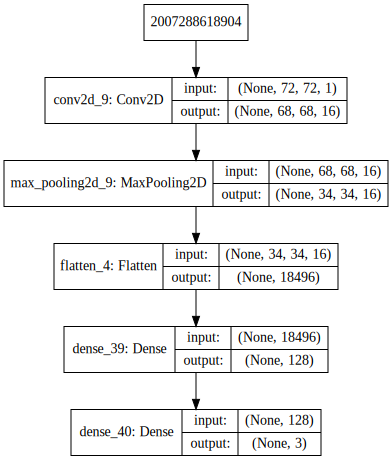

In [209]:
#Model
model=Sequential()
model.add(Conv2D(16,(5,5),activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [210]:
model.fit(X_train,Y_train,epochs=100,batch_size=32)

Epoch 1/100
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0975 - acc: 0.3550
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 1.0951 - acc: 0.3560
Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: 1.0929 - acc: 0.3560A: 3s - loss
Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: 1.0878 - acc: 0.3560
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 1.0620 - acc: 0.4040
Epoch 6/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.9915 - acc: 0.5210
Epoch 7/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.9038 - acc: 0.5980A: 5s
Epoch 8/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8312 - acc: 0.6260
Epoch 9/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.7875 - acc: 0.6370
Epoch 10/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.7611 - acc: 0.6370A: 

In [211]:
[X_test, Y_test] = generate_test_set_classification()
X_test=X_test.reshape(X_test.shape[0],72,72,1)
X_test=X_test.astype('float32')
X_test/=255


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [212]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.8734210954109828, 0.7166666674613953]

<div class="alert alert-info">
<b>>=99% accuracy and 0.17 loss for training data (free shapes images).
    
    
71.7% accuracy and 0.87 loss for the generated test data (free shapes images too).

</b>
</div>

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

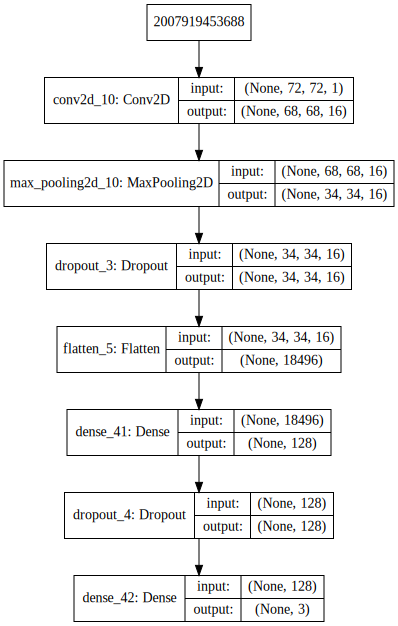

In [213]:
#Increasing number of samples
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
Y_train=np_utils.to_categorical(Y_train,num_classes=3)
X_train=X_train.reshape(X_train.shape[0],72,72,1)
X_train=X_train.astype('float32')

#Model: Adding 2 dropout layers
model=Sequential()
model.add(Conv2D(16,(5,5),activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0,5))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [214]:
model.fit(X_train,Y_train,epochs=100,batch_size=128)

Epoch 1/100
3000/3000 [==============================] - 11s 4ms/step - loss: 1.2181 - acc: 0.4977
Epoch 2/100
3000/3000 [==============================] - 10s 3ms/step - loss: 0.7967 - acc: 0.7170
Epoch 3/100
3000/3000 [==============================] - 10s 3ms/step - loss: 0.6233 - acc: 0.7697
Epoch 4/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5309 - acc: 0.8120
Epoch 5/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.4419 - acc: 0.8567
Epoch 6/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.3789 - acc: 0.8830
Epoch 7/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.3330 - acc: 0.8947
Epoch 8/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.3118 - acc: 0.8980
Epoch 9/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.2680 - acc: 0.9223
Epoch 10/100
3000/3000 [==============================] - 9s 3ms/step - loss: 0.2517 - acc: 0.9263
Epoch 11/100
300

In [215]:
[X_test, Y_test] = generate_test_set_classification()
X_test=X_test.reshape(X_test.shape[0],72,72,1)
X_test=X_test.astype('float32')

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [216]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 3ms/step


[0.24615167011817296, 0.943333334128062]

<div class="alert alert-info">
<b>With 3000 training samples (free shapes images)</b>

<b>> 99.97% accuracy and 0.003 loss for training data (free shapes images).</b>
      
<b>94.3% accuracy and 0.246 loss for the generated test data (free shapes images too).

</b>
</div>

# A Regression Problem

In [217]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


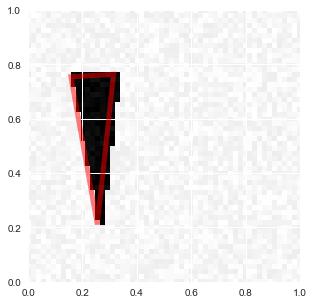

In [227]:
visualize_prediction(X_train[4], Y_train[4])

In [220]:
X_train.shape

(300, 5184)

In [229]:
Y_train.shape

(300, 6)

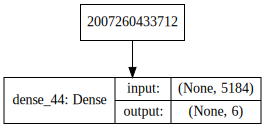

In [231]:
#Model
model=Sequential()
model.add(Dense(6,activation='linear',input_dim=X_train.shape[1]))

model.compile(optimizer=Adam(1e-5),
              loss='mse',
              metrics=['accuracy'])
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [233]:
model.fit(X_train,Y_train,epochs=10000,batch_size=128)

Epoch 1/10000
300/300 [==============================] - 0s 93us/step - loss: 0.1296 - acc: 0.1967
Epoch 2/10000
300/300 [==============================] - 0s 110us/step - loss: 0.1294 - acc: 0.1933
Epoch 3/10000
300/300 [==============================] - 0s 103us/step - loss: 0.1292 - acc: 0.1933
Epoch 4/10000
300/300 [==============================] - 0s 113us/step - loss: 0.1291 - acc: 0.2000
Epoch 5/10000
300/300 [==============================] - 0s 110us/step - loss: 0.1289 - acc: 0.2000
Epoch 6/10000
300/300 [==============================] - 0s 113us/step - loss: 0.1288 - acc: 0.1933
Epoch 7/10000
300/300 [==============================] - 0s 110us/step - loss: 0.1286 - acc: 0.1933
Epoch 8/10000
300/300 [==============================] - 0s 113us/step - loss: 0.1287 - acc: 0.1867
Epoch 9/10000
300/300 [==============================] - 0s 136us/step - loss: 0.1284 - acc: 0.1933
Epoch 10/10000
300/300 [==============================] - 0s 110us/step - loss: 0.1281 - acc: 0.1900


300/300 [==============================] - 0s 123us/step - loss: 0.1074 - acc: 0.2167
Epoch 162/10000
300/300 [==============================] - ETA: 0s - loss: 0.1071 - acc: 0.210 - 0s 130us/step - loss: 0.1074 - acc: 0.2100
Epoch 163/10000
300/300 [==============================] - 0s 133us/step - loss: 0.1072 - acc: 0.2100
Epoch 164/10000
300/300 [==============================] - 0s 123us/step - loss: 0.1070 - acc: 0.2100
Epoch 165/10000
300/300 [==============================] - 0s 140us/step - loss: 0.1069 - acc: 0.2067
Epoch 166/10000
300/300 [==============================] - 0s 133us/step - loss: 0.1068 - acc: 0.2100
Epoch 167/10000
300/300 [==============================] - 0s 116us/step - loss: 0.1068 - acc: 0.2200
Epoch 168/10000
300/300 [==============================] - 0s 133us/step - loss: 0.1067 - acc: 0.2167
Epoch 169/10000
300/300 [==============================] - 0s 143us/step - loss: 0.1065 - acc: 0.2167
Epoch 170/10000
300/300 [==============================] - 0

300/300 [==============================] - 0s 150us/step - loss: 0.0996 - acc: 0.2200
Epoch 242/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0994 - acc: 0.2233
Epoch 243/10000
300/300 [==============================] - 0s 156us/step - loss: 0.0994 - acc: 0.2233
Epoch 244/10000
300/300 [==============================] - 0s 156us/step - loss: 0.0994 - acc: 0.2267
Epoch 245/10000
300/300 [==============================] - 0s 150us/step - loss: 0.0993 - acc: 0.2200
Epoch 246/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0992 - acc: 0.2167
Epoch 247/10000
300/300 [==============================] - 0s 140us/step - loss: 0.0991 - acc: 0.2200
Epoch 248/10000
300/300 [==============================] - ETA: 0s - loss: 0.1050 - acc: 0.203 - 0s 140us/step - loss: 0.0990 - acc: 0.2233
Epoch 249/10000
300/300 [==============================] - 0s 140us/step - loss: 0.0989 - acc: 0.2233
Epoch 250/10000
300/300 [==============================] - 0

300/300 [==============================] - 0s 110us/step - loss: 0.0933 - acc: 0.2333
Epoch 322/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0933 - acc: 0.2300
Epoch 323/10000
300/300 [==============================] - 0s 150us/step - loss: 0.0931 - acc: 0.2267
Epoch 324/10000
300/300 [==============================] - 0s 206us/step - loss: 0.0931 - acc: 0.2233
Epoch 325/10000
300/300 [==============================] - 0s 150us/step - loss: 0.0931 - acc: 0.2200
Epoch 326/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0931 - acc: 0.2133
Epoch 327/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0929 - acc: 0.2233
Epoch 328/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0928 - acc: 0.2233
Epoch 329/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0927 - acc: 0.2167
Epoch 330/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0927 - acc: 0.22

300/300 [==============================] - 0s 140us/step - loss: 0.0881 - acc: 0.2533
Epoch 402/10000
300/300 [==============================] - ETA: 0s - loss: 0.0916 - acc: 0.242 - 0s 133us/step - loss: 0.0881 - acc: 0.2300
Epoch 403/10000
300/300 [==============================] - 0s 146us/step - loss: 0.0881 - acc: 0.2333
Epoch 404/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0881 - acc: 0.2267
Epoch 405/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0880 - acc: 0.2367
Epoch 406/10000
300/300 [==============================] - 0s 143us/step - loss: 0.0879 - acc: 0.2400
Epoch 407/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0880 - acc: 0.2533
Epoch 408/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0877 - acc: 0.2467
Epoch 409/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0878 - acc: 0.2367
Epoch 410/10000
300/300 [==============================] - 0

300/300 [==============================] - 0s 133us/step - loss: 0.0802 - acc: 0.2500
Epoch 562/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0802 - acc: 0.2400
Epoch 563/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0801 - acc: 0.2467
Epoch 564/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0800 - acc: 0.2633
Epoch 565/10000
300/300 [==============================] - 0s 140us/step - loss: 0.0801 - acc: 0.2600
Epoch 566/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0800 - acc: 0.2600
Epoch 567/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0799 - acc: 0.2500
Epoch 568/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0799 - acc: 0.2433
Epoch 569/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0799 - acc: 0.2433
Epoch 570/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0798 - acc: 0.2

300/300 [==============================] - 0s 80us/step - loss: 0.0743 - acc: 0.2700
Epoch 722/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0742 - acc: 0.2633
Epoch 723/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0742 - acc: 0.2833
Epoch 724/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0741 - acc: 0.2700
Epoch 725/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0741 - acc: 0.2733
Epoch 726/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0739 - acc: 0.2867
Epoch 727/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0740 - acc: 0.2733
Epoch 728/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0742 - acc: 0.2800
Epoch 729/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0740 - acc: 0.2833
Epoch 730/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0739 - acc: 0.2667
Epoch 

300/300 [==============================] - 0s 130us/step - loss: 0.0690 - acc: 0.2900
Epoch 882/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0691 - acc: 0.2933
Epoch 883/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0691 - acc: 0.3000
Epoch 884/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0692 - acc: 0.2900
Epoch 885/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0691 - acc: 0.3000
Epoch 886/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0691 - acc: 0.2933
Epoch 887/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0691 - acc: 0.2867
Epoch 888/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0690 - acc: 0.2933
Epoch 889/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0689 - acc: 0.2933
Epoch 890/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0688 - acc: 0.2933


300/300 [==============================] - 0s 83us/step - loss: 0.0647 - acc: 0.3100
Epoch 1042/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0647 - acc: 0.3167
Epoch 1043/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0646 - acc: 0.3233
Epoch 1044/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0646 - acc: 0.3200
Epoch 1045/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0646 - acc: 0.3233
Epoch 1046/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0644 - acc: 0.3200
Epoch 1047/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0646 - acc: 0.2967
Epoch 1048/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0646 - acc: 0.3000
Epoch 1049/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0645 - acc: 0.3167
Epoch 1050/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0645 - acc: 0.31

300/300 [==============================] - 0s 83us/step - loss: 0.0606 - acc: 0.3333
Epoch 1201/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0605 - acc: 0.3433
Epoch 1202/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0606 - acc: 0.3433
Epoch 1203/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0606 - acc: 0.3500
Epoch 1204/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0606 - acc: 0.3400
Epoch 1205/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0605 - acc: 0.3367
Epoch 1206/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0605 - acc: 0.3400
Epoch 1207/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0605 - acc: 0.3433
Epoch 1208/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0604 - acc: 0.3300
Epoch 1209/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0603 - acc: 

300/300 [==============================] - 0s 80us/step - loss: 0.0587 - acc: 0.3433
Epoch 1281/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0587 - acc: 0.3533
Epoch 1282/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0587 - acc: 0.3500
Epoch 1283/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0587 - acc: 0.3600
Epoch 1284/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0587 - acc: 0.3533
Epoch 1285/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0585 - acc: 0.3567
Epoch 1286/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0587 - acc: 0.3500
Epoch 1287/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0586 - acc: 0.3333
Epoch 1288/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0584 - acc: 0.3567
Epoch 1289/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0585 - acc: 0.

300/300 [==============================] - 0s 216us/step - loss: 0.0552 - acc: 0.3667
Epoch 1438/10000
300/300 [==============================] - 0s 170us/step - loss: 0.0551 - acc: 0.3633
Epoch 1439/10000
300/300 [==============================] - 0s 206us/step - loss: 0.0550 - acc: 0.3667
Epoch 1440/10000
300/300 [==============================] - 0s 150us/step - loss: 0.0550 - acc: 0.3733
Epoch 1441/10000
300/300 [==============================] - 0s 160us/step - loss: 0.0550 - acc: 0.3667
Epoch 1442/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0549 - acc: 0.3633
Epoch 1443/10000
300/300 [==============================] - 0s 199us/step - loss: 0.0549 - acc: 0.3700
Epoch 1444/10000
300/300 [==============================] - 0s 186us/step - loss: 0.0549 - acc: 0.3733
Epoch 1445/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0548 - acc: 0.3700
Epoch 1446/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0549 -

Epoch 1595/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0518 - acc: 0.3867
Epoch 1596/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0517 - acc: 0.3867
Epoch 1597/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0517 - acc: 0.3900
Epoch 1598/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0518 - acc: 0.3867
Epoch 1599/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0517 - acc: 0.3833
Epoch 1600/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0516 - acc: 0.3833
Epoch 1601/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0516 - acc: 0.3933
Epoch 1602/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0516 - acc: 0.3933
Epoch 1603/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0515 - acc: 0.3767
Epoch 1604/10000
300/300 [==============================] - 0s 86us/step - loss: 0

300/300 [==============================] - 0s 93us/step - loss: 0.0487 - acc: 0.3967
Epoch 1755/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0486 - acc: 0.4133
Epoch 1756/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0486 - acc: 0.4000
Epoch 1757/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0487 - acc: 0.3967
Epoch 1758/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0486 - acc: 0.4000
Epoch 1759/10000
300/300 [==============================] - 0s 140us/step - loss: 0.0486 - acc: 0.4100
Epoch 1760/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0486 - acc: 0.4000
Epoch 1761/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0484 - acc: 0.4067
Epoch 1762/10000
300/300 [==============================] - 0s 140us/step - loss: 0.0486 - acc: 0.3933
Epoch 1763/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0485 - a

300/300 [==============================] - 0s 86us/step - loss: 0.0459 - acc: 0.4167
Epoch 1914/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0458 - acc: 0.4300
Epoch 1915/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0458 - acc: 0.4167
Epoch 1916/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0457 - acc: 0.4067
Epoch 1917/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0458 - acc: 0.4067
Epoch 1918/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0456 - acc: 0.4167
Epoch 1919/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0457 - acc: 0.4233
Epoch 1920/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0456 - acc: 0.4267
Epoch 1921/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0456 - acc: 0.4233
Epoch 1922/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0456 - acc: 0.40

300/300 [==============================] - 0s 86us/step - loss: 0.0431 - acc: 0.4367
Epoch 2074/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0430 - acc: 0.4233
Epoch 2075/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0432 - acc: 0.4233
Epoch 2076/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0429 - acc: 0.4467
Epoch 2077/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0431 - acc: 0.4133
Epoch 2078/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0430 - acc: 0.4233
Epoch 2079/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0430 - acc: 0.4333
Epoch 2080/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0431 - acc: 0.4367
Epoch 2081/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0429 - acc: 0.4300
Epoch 2082/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0429 - acc: 0.

300/300 [==============================] - 0s 123us/step - loss: 0.0405 - acc: 0.4567
Epoch 2232/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0405 - acc: 0.4467
Epoch 2233/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0406 - acc: 0.4433
Epoch 2234/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0405 - acc: 0.4567
Epoch 2235/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0406 - acc: 0.4633
Epoch 2236/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0405 - acc: 0.4433
Epoch 2237/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0405 - acc: 0.4500
Epoch 2238/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0405 - acc: 0.4433
Epoch 2239/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0405 - acc: 0.4633
Epoch 2240/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0404 -

300/300 [==============================] - 0s 120us/step - loss: 0.0382 - acc: 0.4733
Epoch 2390/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0383 - acc: 0.4733
Epoch 2391/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0385 - acc: 0.4800
Epoch 2392/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0382 - acc: 0.4633
Epoch 2393/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0384 - acc: 0.4700
Epoch 2394/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0382 - acc: 0.4733
Epoch 2395/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0383 - acc: 0.4700
Epoch 2396/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0382 - acc: 0.4567
Epoch 2397/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0382 - acc: 0.4700
Epoch 2398/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0381 - ac

300/300 [==============================] - 0s 123us/step - loss: 0.0362 - acc: 0.4900
Epoch 2548/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0361 - acc: 0.4967
Epoch 2549/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0361 - acc: 0.4867
Epoch 2550/10000
300/300 [==============================] - 0s 146us/step - loss: 0.0361 - acc: 0.4933
Epoch 2551/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0360 - acc: 0.4900
Epoch 2552/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0362 - acc: 0.4933
Epoch 2553/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0361 - acc: 0.4800
Epoch 2554/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0360 - acc: 0.4933
Epoch 2555/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0360 - acc: 0.4833
Epoch 2556/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0360 - 

300/300 [==============================] - 0s 136us/step - loss: 0.0350 - acc: 0.4933
Epoch 2628/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0350 - acc: 0.4967
Epoch 2629/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0350 - acc: 0.5000
Epoch 2630/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0350 - acc: 0.4900
Epoch 2631/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0350 - acc: 0.4933
Epoch 2632/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0350 - acc: 0.4967
Epoch 2633/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0349 - acc: 0.4967
Epoch 2634/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0349 - acc: 0.5000
Epoch 2635/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0350 - acc: 0.4967
Epoch 2636/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0350 -

300/300 [==============================] - 0s 120us/step - loss: 0.0330 - acc: 0.5100
Epoch 2787/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0332 - acc: 0.5167
Epoch 2788/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0331 - acc: 0.5167
Epoch 2789/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0331 - acc: 0.5067
Epoch 2790/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0330 - acc: 0.5033
Epoch 2791/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0330 - acc: 0.5067
Epoch 2792/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0330 - acc: 0.5200
Epoch 2793/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0331 - acc: 0.4967
Epoch 2794/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0331 - acc: 0.4967
Epoch 2795/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0330 -

Epoch 2866/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0322 - acc: 0.5133
Epoch 2867/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0322 - acc: 0.5100
Epoch 2868/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0321 - acc: 0.5133
Epoch 2869/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0321 - acc: 0.5100
Epoch 2870/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0320 - acc: 0.5267
Epoch 2871/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0322 - acc: 0.5133
Epoch 2872/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0321 - acc: 0.5067
Epoch 2873/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0321 - acc: 0.5200
Epoch 2874/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0320 - acc: 0.5133
Epoch 2875/10000
300/300 [==============================] - 0s 86us/step -

300/300 [==============================] - 0s 123us/step - loss: 0.0304 - acc: 0.5333
Epoch 3025/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0304 - acc: 0.5433
Epoch 3026/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0304 - acc: 0.5400
Epoch 3027/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0304 - acc: 0.5433
Epoch 3028/10000
300/300 [==============================] - 0s 143us/step - loss: 0.0303 - acc: 0.5400
Epoch 3029/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0304 - acc: 0.5333
Epoch 3030/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0304 - acc: 0.5467
Epoch 3031/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0303 - acc: 0.5267
Epoch 3032/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0304 - acc: 0.5333
Epoch 3033/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0303 -

300/300 [==============================] - 0s 93us/step - loss: 0.0287 - acc: 0.5600
Epoch 3183/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0287 - acc: 0.5367
Epoch 3184/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0287 - acc: 0.5467
Epoch 3185/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0288 - acc: 0.5567
Epoch 3186/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0287 - acc: 0.5500
Epoch 3187/10000
300/300 [==============================] - ETA: 0s - loss: 0.0275 - acc: 0.539 - 0s 90us/step - loss: 0.0287 - acc: 0.5467
Epoch 3188/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0287 - acc: 0.5433
Epoch 3189/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0286 - acc: 0.5533
Epoch 3190/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0286 - acc: 0.5500
Epoch 3191/10000
300/300 [==============================] -

300/300 [==============================] - 0s 116us/step - loss: 0.0271 - acc: 0.5667
Epoch 3341/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0272 - acc: 0.5700
Epoch 3342/10000
300/300 [==============================] - 0s 176us/step - loss: 0.0272 - acc: 0.5600
Epoch 3343/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0272 - acc: 0.5633
Epoch 3344/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0271 - acc: 0.5667
Epoch 3345/10000
300/300 [==============================] - 0s 160us/step - loss: 0.0271 - acc: 0.5667
Epoch 3346/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0271 - acc: 0.5800
Epoch 3347/10000
300/300 [==============================] - ETA: 0s - loss: 0.0284 - acc: 0.570 - 0s 143us/step - loss: 0.0271 - acc: 0.5667
Epoch 3348/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0271 - acc: 0.5567
Epoch 3349/10000
300/300 [==========================

300/300 [==============================] - 0s 113us/step - loss: 0.0258 - acc: 0.5733
Epoch 3500/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0257 - acc: 0.5700
Epoch 3501/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0257 - acc: 0.5833
Epoch 3502/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0259 - acc: 0.5767
Epoch 3503/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0258 - acc: 0.5867
Epoch 3504/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0259 - acc: 0.5733
Epoch 3505/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0257 - acc: 0.5733
Epoch 3506/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0259 - acc: 0.5767
Epoch 3507/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0256 - acc: 0.5800
Epoch 3508/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0256 - acc: 0.5

300/300 [==============================] - 0s 103us/step - loss: 0.0250 - acc: 0.5700
Epoch 3580/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0250 - acc: 0.5833
Epoch 3581/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0250 - acc: 0.5767
Epoch 3582/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0250 - acc: 0.5867
Epoch 3583/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0250 - acc: 0.5933
Epoch 3584/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0251 - acc: 0.5667
Epoch 3585/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0250 - acc: 0.5800
Epoch 3586/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0251 - acc: 0.5933
Epoch 3587/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0249 - acc: 0.5867
Epoch 3588/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0250 - 

Epoch 3659/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0244 - acc: 0.6100
Epoch 3660/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0243 - acc: 0.5933
Epoch 3661/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0243 - acc: 0.5767
Epoch 3662/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0243 - acc: 0.5833
Epoch 3663/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0244 - acc: 0.5933
Epoch 3664/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0243 - acc: 0.6000
Epoch 3665/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0244 - acc: 0.5833
Epoch 3666/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0243 - acc: 0.5833
Epoch 3667/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0243 - acc: 0.5800
Epoch 3668/10000
300/300 [==============================] - 0s 83us/step - loss: 0

300/300 [==============================] - 0s 80us/step - loss: 0.0230 - acc: 0.5967
Epoch 3819/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0231 - acc: 0.6000
Epoch 3820/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0230 - acc: 0.5967
Epoch 3821/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0230 - acc: 0.5933
Epoch 3822/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0230 - acc: 0.5867
Epoch 3823/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0230 - acc: 0.6000
Epoch 3824/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0230 - acc: 0.6000
Epoch 3825/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0229 - acc: 0.5967
Epoch 3826/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0229 - acc: 0.5900
Epoch 3827/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0229 - acc: 0.60

300/300 [==============================] - 0s 100us/step - loss: 0.0224 - acc: 0.5933
Epoch 3899/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0224 - acc: 0.5933
Epoch 3900/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0223 - acc: 0.6067
Epoch 3901/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0223 - acc: 0.5900
Epoch 3902/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0223 - acc: 0.6000
Epoch 3903/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0223 - acc: 0.6033
Epoch 3904/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0223 - acc: 0.6000
Epoch 3905/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0223 - acc: 0.5933
Epoch 3906/10000
300/300 [==============================] - 0s 76us/step - loss: 0.0224 - acc: 0.6200
Epoch 3907/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0223 - acc

300/300 [==============================] - 0s 93us/step - loss: 0.0212 - acc: 0.6033
Epoch 4059/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0212 - acc: 0.6333
Epoch 4060/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0211 - acc: 0.6100
Epoch 4061/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0211 - acc: 0.5900
Epoch 4062/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0212 - acc: 0.6100
Epoch 4063/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0212 - acc: 0.6133
Epoch 4064/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0211 - acc: 0.6233
Epoch 4065/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0212 - acc: 0.6000
Epoch 4066/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0211 - acc: 0.6033
Epoch 4067/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0211 - acc: 

300/300 [==============================] - 0s 83us/step - loss: 0.0201 - acc: 0.6200
Epoch 4218/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0200 - acc: 0.6133
Epoch 4219/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0201 - acc: 0.6267
Epoch 4220/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0201 - acc: 0.6200
Epoch 4221/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0201 - acc: 0.6167
Epoch 4222/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0199 - acc: 0.6267
Epoch 4223/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0203 - acc: 0.6333
Epoch 4224/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0201 - acc: 0.6433
Epoch 4225/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0201 - acc: 0.6200
Epoch 4226/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0201 - acc: 0.6

Epoch 4297/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0196 - acc: 0.6167
Epoch 4298/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0195 - acc: 0.6333
Epoch 4299/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0195 - acc: 0.6300
Epoch 4300/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0195 - acc: 0.6267
Epoch 4301/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0195 - acc: 0.6267
Epoch 4302/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0195 - acc: 0.6367
Epoch 4303/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0194 - acc: 0.6367
Epoch 4304/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0195 - acc: 0.6267
Epoch 4305/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0195 - acc: 0.6267
Epoch 4306/10000
300/300 [==============================] - 0s 96us/step 

Epoch 4377/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0190 - acc: 0.6267
Epoch 4378/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0191 - acc: 0.6200
Epoch 4379/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0189 - acc: 0.6467
Epoch 4380/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0192 - acc: 0.6100
Epoch 4381/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0190 - acc: 0.6300
Epoch 4382/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0190 - acc: 0.6300
Epoch 4383/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0189 - acc: 0.6267
Epoch 4384/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0191 - acc: 0.6400
Epoch 4385/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0189 - acc: 0.6400
Epoch 4386/10000
300/300 [==============================] - 0s 96us/step - 

Epoch 4457/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0185 - acc: 0.6333
Epoch 4458/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0184 - acc: 0.6367
Epoch 4459/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0184 - acc: 0.6267
Epoch 4460/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0184 - acc: 0.6267
Epoch 4461/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0184 - acc: 0.6433
Epoch 4462/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0184 - acc: 0.6467
Epoch 4463/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0184 - acc: 0.6333
Epoch 4464/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0184 - acc: 0.6267
Epoch 4465/10000
300/300 [==============================] - ETA: 0s - loss: 0.0184 - acc: 0.632 - 0s 93us/step - loss: 0.0184 - acc: 0.6367
Epoch 4466/10000
300/300 [===============

Epoch 4616/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0176 - acc: 0.6600
Epoch 4617/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0175 - acc: 0.6533
Epoch 4618/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0175 - acc: 0.6600
Epoch 4619/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0175 - acc: 0.6367
Epoch 4620/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0176 - acc: 0.6433
Epoch 4621/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0175 - acc: 0.6467
Epoch 4622/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0176 - acc: 0.6400
Epoch 4623/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0175 - acc: 0.6433
Epoch 4624/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0176 - acc: 0.6400
Epoch 4625/10000
300/300 [==============================] - 0s 120us/step -

Epoch 4696/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0171 - acc: 0.6533
Epoch 4697/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0170 - acc: 0.6500
Epoch 4698/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0170 - acc: 0.6433
Epoch 4699/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0169 - acc: 0.6567
Epoch 4700/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0170 - acc: 0.6500
Epoch 4701/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0171 - acc: 0.6433
Epoch 4702/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0170 - acc: 0.6467
Epoch 4703/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0170 - acc: 0.6500
Epoch 4704/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0170 - acc: 0.6500
Epoch 4705/10000
300/300 [==============================] - 0s 106us/step

300/300 [==============================] - 0s 86us/step - loss: 0.0161 - acc: 0.6567
Epoch 4856/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0161 - acc: 0.6733
Epoch 4857/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0161 - acc: 0.6600
Epoch 4858/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0160 - acc: 0.6500
Epoch 4859/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0162 - acc: 0.6567
Epoch 4860/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0160 - acc: 0.6633
Epoch 4861/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0160 - acc: 0.6633
Epoch 4862/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0161 - acc: 0.6633
Epoch 4863/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0161 - acc: 0.6633
Epoch 4864/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0161 - acc: 0.66

300/300 [==============================] - 0s 90us/step - loss: 0.0153 - acc: 0.6633
Epoch 5016/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0153 - acc: 0.6633
Epoch 5017/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0155 - acc: 0.6900
Epoch 5018/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0154 - acc: 0.6700
Epoch 5019/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0154 - acc: 0.6533
Epoch 5020/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0153 - acc: 0.6567
Epoch 5021/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0153 - acc: 0.6667
Epoch 5022/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0153 - acc: 0.6733
Epoch 5023/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0153 - acc: 0.6767
Epoch 5024/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0152 - acc: 0.66

300/300 [==============================] - 0s 140us/step - loss: 0.0144 - acc: 0.6900
Epoch 5176/10000
300/300 [==============================] - 0s 176us/step - loss: 0.0146 - acc: 0.6700
Epoch 5177/10000
300/300 [==============================] - 0s 166us/step - loss: 0.0144 - acc: 0.6633
Epoch 5178/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0144 - acc: 0.6933
Epoch 5179/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0144 - acc: 0.6867
Epoch 5180/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0144 - acc: 0.6733
Epoch 5181/10000
300/300 [==============================] - 0s 153us/step - loss: 0.0143 - acc: 0.6833
Epoch 5182/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0145 - acc: 0.6933
Epoch 5183/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0143 - acc: 0.6733
Epoch 5184/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0144 -

300/300 [==============================] - 0s 96us/step - loss: 0.0136 - acc: 0.6900
Epoch 5334/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0136 - acc: 0.7033
Epoch 5335/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0136 - acc: 0.7000
Epoch 5336/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0137 - acc: 0.6833
Epoch 5337/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0136 - acc: 0.6967
Epoch 5338/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0137 - acc: 0.7000
Epoch 5339/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0137 - acc: 0.6867
Epoch 5340/10000
300/300 [==============================] - ETA: 0s - loss: 0.0141 - acc: 0.640 - 0s 130us/step - loss: 0.0137 - acc: 0.7000
Epoch 5341/10000
300/300 [==============================] - 0s 143us/step - loss: 0.0136 - acc: 0.7033
Epoch 5342/10000
300/300 [===========================

300/300 [==============================] - 0s 110us/step - loss: 0.0129 - acc: 0.7067
Epoch 5492/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0130 - acc: 0.7100
Epoch 5493/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0129 - acc: 0.7000
Epoch 5494/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0129 - acc: 0.6900
Epoch 5495/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0129 - acc: 0.7133
Epoch 5496/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0129 - acc: 0.7167
Epoch 5497/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0130 - acc: 0.6933
Epoch 5498/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0128 - acc: 0.7033
Epoch 5499/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0130 - acc: 0.7067
Epoch 5500/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0129 - a

300/300 [==============================] - 0s 120us/step - loss: 0.0124 - acc: 0.6900
Epoch 5650/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0122 - acc: 0.7200
Epoch 5651/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0122 - acc: 0.7233
Epoch 5652/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0122 - acc: 0.7033
Epoch 5653/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0122 - acc: 0.7000
Epoch 5654/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0121 - acc: 0.7067
Epoch 5655/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0122 - acc: 0.7300
Epoch 5656/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0123 - acc: 0.7167
Epoch 5657/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0122 - acc: 0.7167
Epoch 5658/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0122 - a

300/300 [==============================] - 0s 116us/step - loss: 0.0116 - acc: 0.7267
Epoch 5808/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0116 - acc: 0.7267
Epoch 5809/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0116 - acc: 0.7300
Epoch 5810/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0116 - acc: 0.7233
Epoch 5811/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0115 - acc: 0.7200
Epoch 5812/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0116 - acc: 0.7200
Epoch 5813/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0115 - acc: 0.7267
Epoch 5814/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0115 - acc: 0.7133
Epoch 5815/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0115 - acc: 0.7200
Epoch 5816/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0115 -

300/300 [==============================] - 0s 106us/step - loss: 0.0110 - acc: 0.7300
Epoch 5966/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0109 - acc: 0.7367
Epoch 5967/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0109 - acc: 0.7333
Epoch 5968/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0109 - acc: 0.7367
Epoch 5969/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0109 - acc: 0.7300
Epoch 5970/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0109 - acc: 0.7233
Epoch 5971/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0109 - acc: 0.7367
Epoch 5972/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0109 - acc: 0.7400
Epoch 5973/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0109 - acc: 0.7300
Epoch 5974/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0109 -

300/300 [==============================] - 0s 110us/step - loss: 0.0104 - acc: 0.7533
Epoch 6124/10000
300/300 [==============================] - ETA: 0s - loss: 0.0109 - acc: 0.726 - 0s 116us/step - loss: 0.0104 - acc: 0.7433
Epoch 6125/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0103 - acc: 0.7300
Epoch 6126/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0103 - acc: 0.7333
Epoch 6127/10000
300/300 [==============================] - 0s 160us/step - loss: 0.0103 - acc: 0.7433
Epoch 6128/10000
300/300 [==============================] - 0s 160us/step - loss: 0.0103 - acc: 0.7467
Epoch 6129/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0103 - acc: 0.7333
Epoch 6130/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0103 - acc: 0.7433
Epoch 6131/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0103 - acc: 0.7367
Epoch 6132/10000
300/300 [==========================

300/300 [==============================] - 0s 83us/step - loss: 0.0098 - acc: 0.7567
Epoch 6283/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0098 - acc: 0.7333
Epoch 6284/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0097 - acc: 0.7467
Epoch 6285/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0097 - acc: 0.7500
Epoch 6286/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0097 - acc: 0.7467
Epoch 6287/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0097 - acc: 0.7433
Epoch 6288/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0097 - acc: 0.7400
Epoch 6289/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0097 - acc: 0.7433
Epoch 6290/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0097 - acc: 0.7533
Epoch 6291/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0097 - acc: 0.7

300/300 [==============================] - 0s 113us/step - loss: 0.0092 - acc: 0.7367
Epoch 6443/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0092 - acc: 0.7500
Epoch 6444/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0093 - acc: 0.7600
Epoch 6445/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0092 - acc: 0.7467
Epoch 6446/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0092 - acc: 0.7367
Epoch 6447/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0092 - acc: 0.7667
Epoch 6448/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0092 - acc: 0.7433
Epoch 6449/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0092 - acc: 0.7300
Epoch 6450/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0092 - acc: 0.7400
Epoch 6451/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0092 - ac

Epoch 6602/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0087 - acc: 0.7467
Epoch 6603/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0086 - acc: 0.7500
Epoch 6604/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0087 - acc: 0.7567
Epoch 6605/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0087 - acc: 0.7600
Epoch 6606/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0086 - acc: 0.7500
Epoch 6607/10000
300/300 [==============================] - 0s 146us/step - loss: 0.0088 - acc: 0.7367
Epoch 6608/10000
300/300 [==============================] - 0s 146us/step - loss: 0.0087 - acc: 0.7533
Epoch 6609/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0087 - acc: 0.7600
Epoch 6610/10000
300/300 [==============================] - 0s 130us/step - loss: 0.0086 - acc: 0.7600
Epoch 6611/10000
300/300 [==============================] - 0s 136us/step -

300/300 [==============================] - 0s 130us/step - loss: 0.0082 - acc: 0.7633
Epoch 6761/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0082 - acc: 0.7633
Epoch 6762/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0082 - acc: 0.7567
Epoch 6763/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0082 - acc: 0.7700
Epoch 6764/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0082 - acc: 0.7567
Epoch 6765/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0082 - acc: 0.7500
Epoch 6766/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0082 - acc: 0.7567
Epoch 6767/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0082 - acc: 0.7533
Epoch 6768/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0082 - acc: 0.7467
Epoch 6769/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0082 - 

300/300 [==============================] - 0s 103us/step - loss: 0.0077 - acc: 0.7567
Epoch 6919/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0078 - acc: 0.7667
Epoch 6920/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0077 - acc: 0.7600
Epoch 6921/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0078 - acc: 0.7433
Epoch 6922/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0077 - acc: 0.7667
Epoch 6923/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0077 - acc: 0.7767
Epoch 6924/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0077 - acc: 0.7600
Epoch 6925/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0077 - acc: 0.7700
Epoch 6926/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0077 - acc: 0.7833
Epoch 6927/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0077 - 

300/300 [==============================] - 0s 106us/step - loss: 0.0073 - acc: 0.7667
Epoch 7077/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0072 - acc: 0.7700
Epoch 7078/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0073 - acc: 0.7667
Epoch 7079/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0073 - acc: 0.7567
Epoch 7080/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0073 - acc: 0.7833
Epoch 7081/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0072 - acc: 0.7800
Epoch 7082/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0073 - acc: 0.7667
Epoch 7083/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0073 - acc: 0.7700
Epoch 7084/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0072 - acc: 0.7800
Epoch 7085/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0072 - 

300/300 [==============================] - 0s 106us/step - loss: 0.0069 - acc: 0.7800
Epoch 7235/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0069 - acc: 0.7733
Epoch 7236/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0069 - acc: 0.7667
Epoch 7237/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0068 - acc: 0.7733
Epoch 7238/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0068 - acc: 0.7867
Epoch 7239/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0068 - acc: 0.7800
Epoch 7240/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0068 - acc: 0.7800
Epoch 7241/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0068 - acc: 0.7933
Epoch 7242/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0068 - acc: 0.7700
Epoch 7243/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0068 - 

300/300 [==============================] - 0s 106us/step - loss: 0.0068 - acc: 0.7700
Epoch 7314/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0067 - acc: 0.7733
Epoch 7315/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0068 - acc: 0.7800
Epoch 7316/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0067 - acc: 0.7667
Epoch 7317/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0067 - acc: 0.7700
Epoch 7318/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0067 - acc: 0.7867
Epoch 7319/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0068 - acc: 0.7700
Epoch 7320/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0067 - acc: 0.7733
Epoch 7321/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0068 - acc: 0.7800
Epoch 7322/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0068 - 

300/300 [==============================] - 0s 140us/step - loss: 0.0063 - acc: 0.7900
Epoch 7472/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0063 - acc: 0.7767
Epoch 7473/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0062 - acc: 0.7767
Epoch 7474/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0063 - acc: 0.7867
Epoch 7475/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0063 - acc: 0.7867
Epoch 7476/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0062 - acc: 0.7867
Epoch 7477/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0063 - acc: 0.7733
Epoch 7478/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0062 - acc: 0.7967
Epoch 7479/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0063 - acc: 0.7900
Epoch 7480/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0063 -

300/300 [==============================] - 0s 116us/step - loss: 0.0059 - acc: 0.7733
Epoch 7630/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0060 - acc: 0.7900
Epoch 7631/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0059 - acc: 0.7867
Epoch 7632/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0059 - acc: 0.7933
Epoch 7633/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0059 - acc: 0.7933
Epoch 7634/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0059 - acc: 0.7833
Epoch 7635/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0059 - acc: 0.7933
Epoch 7636/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0059 - acc: 0.7933
Epoch 7637/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0059 - acc: 0.7800
Epoch 7638/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0060 -

300/300 [==============================] - 0s 106us/step - loss: 0.0056 - acc: 0.8000
Epoch 7788/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0056 - acc: 0.8000
Epoch 7789/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0056 - acc: 0.7900
Epoch 7790/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0055 - acc: 0.7967
Epoch 7791/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0055 - acc: 0.8000
Epoch 7792/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0055 - acc: 0.7967
Epoch 7793/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0056 - acc: 0.7867
Epoch 7794/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0055 - acc: 0.8033
Epoch 7795/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0056 - acc: 0.7833
Epoch 7796/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0055 -

Epoch 7945/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0053 - acc: 0.8000
Epoch 7946/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0053 - acc: 0.7967
Epoch 7947/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0053 - acc: 0.7867
Epoch 7948/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0053 - acc: 0.7967
Epoch 7949/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0052 - acc: 0.8067
Epoch 7950/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0053 - acc: 0.7933
Epoch 7951/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0052 - acc: 0.8100
Epoch 7952/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0053 - acc: 0.8167
Epoch 7953/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0052 - acc: 0.7967
Epoch 7954/10000
300/300 [==============================] - 0s 106us/step

300/300 [==============================] - 0s 83us/step - loss: 0.0049 - acc: 0.8067
Epoch 8105/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0049 - acc: 0.8033
Epoch 8106/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0049 - acc: 0.8000
Epoch 8107/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0049 - acc: 0.7967
Epoch 8108/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0049 - acc: 0.8100
Epoch 8109/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0049 - acc: 0.7933
Epoch 8110/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0049 - acc: 0.8000
Epoch 8111/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0050 - acc: 0.7933
Epoch 8112/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0049 - acc: 0.8067
Epoch 8113/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0049 - acc: 0.8

300/300 [==============================] - 0s 86us/step - loss: 0.0046 - acc: 0.8000
Epoch 8265/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0047 - acc: 0.8000
Epoch 8266/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0046 - acc: 0.8067
Epoch 8267/10000
300/300 [==============================] - 0s 90us/step - loss: 0.0046 - acc: 0.8033
Epoch 8268/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0046 - acc: 0.7967
Epoch 8269/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0046 - acc: 0.8100
Epoch 8270/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0046 - acc: 0.8100
Epoch 8271/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0046 - acc: 0.8133
Epoch 8272/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0046 - acc: 0.8000
Epoch 8273/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0046 - acc: 0.81

300/300 [==============================] - 0s 83us/step - loss: 0.0045 - acc: 0.8200
Epoch 8345/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0045 - acc: 0.8133
Epoch 8346/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0045 - acc: 0.8100
Epoch 8347/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0045 - acc: 0.8133
Epoch 8348/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0045 - acc: 0.8033
Epoch 8349/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0044 - acc: 0.8167
Epoch 8350/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0045 - acc: 0.8200
Epoch 8351/10000
300/300 [==============================] - 0s 80us/step - loss: 0.0045 - acc: 0.8033
Epoch 8352/10000
300/300 [==============================] - 0s 86us/step - loss: 0.0045 - acc: 0.8167
Epoch 8353/10000
300/300 [==============================] - 0s 83us/step - loss: 0.0045 - acc: 0.81

300/300 [==============================] - 0s 116us/step - loss: 0.0042 - acc: 0.8100
Epoch 8505/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0042 - acc: 0.8033
Epoch 8506/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0042 - acc: 0.8100
Epoch 8507/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0042 - acc: 0.8067
Epoch 8508/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0042 - acc: 0.8100
Epoch 8509/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0042 - acc: 0.8033
Epoch 8510/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0042 - acc: 0.8133
Epoch 8511/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0042 - acc: 0.8167
Epoch 8512/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0042 - acc: 0.8033
Epoch 8513/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0042 -

300/300 [==============================] - 0s 106us/step - loss: 0.0039 - acc: 0.8200
Epoch 8664/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0040 - acc: 0.8033
Epoch 8665/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0039 - acc: 0.8267
Epoch 8666/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0039 - acc: 0.8200
Epoch 8667/10000
300/300 [==============================] - 0s 93us/step - loss: 0.0039 - acc: 0.8067
Epoch 8668/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0039 - acc: 0.8200
Epoch 8669/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0039 - acc: 0.8233
Epoch 8670/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0039 - acc: 0.8200
Epoch 8671/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0039 - acc: 0.8133
Epoch 8672/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0039 - a

300/300 [==============================] - 0s 103us/step - loss: 0.0037 - acc: 0.8233
Epoch 8822/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0037 - acc: 0.8200
Epoch 8823/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0037 - acc: 0.8267
Epoch 8824/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0037 - acc: 0.8233
Epoch 8825/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0037 - acc: 0.8200
Epoch 8826/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0036 - acc: 0.8267
Epoch 8827/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0037 - acc: 0.8267
Epoch 8828/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0037 - acc: 0.8267
Epoch 8829/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0037 - acc: 0.8233
Epoch 8830/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0037 -

300/300 [==============================] - 0s 110us/step - loss: 0.0035 - acc: 0.8200
Epoch 8980/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0034 - acc: 0.8333
Epoch 8981/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0035 - acc: 0.8333
Epoch 8982/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0034 - acc: 0.8233
Epoch 8983/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0035 - acc: 0.8367
Epoch 8984/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0034 - acc: 0.8267
Epoch 8985/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0035 - acc: 0.8233
Epoch 8986/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0034 - acc: 0.8333
Epoch 8987/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0034 - acc: 0.8267
Epoch 8988/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0035 -

300/300 [==============================] - 0s 93us/step - loss: 0.0032 - acc: 0.8300
Epoch 9138/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0032 - acc: 0.8333
Epoch 9139/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0032 - acc: 0.8300
Epoch 9140/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0032 - acc: 0.8367
Epoch 9141/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0032 - acc: 0.8400
Epoch 9142/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0032 - acc: 0.8300
Epoch 9143/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0032 - acc: 0.8367
Epoch 9144/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0032 - acc: 0.8333
Epoch 9145/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0032 - acc: 0.8367
Epoch 9146/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0032 - a

300/300 [==============================] - 0s 106us/step - loss: 0.0031 - acc: 0.8400
Epoch 9296/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0030 - acc: 0.8367
Epoch 9297/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0031 - acc: 0.8367
Epoch 9298/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0030 - acc: 0.8300
Epoch 9299/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0031 - acc: 0.8233
Epoch 9300/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0030 - acc: 0.8433
Epoch 9301/10000
300/300 [==============================] - 0s 126us/step - loss: 0.0030 - acc: 0.8467
Epoch 9302/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0030 - acc: 0.8367
Epoch 9303/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0030 - acc: 0.8400
Epoch 9304/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0030 - 

300/300 [==============================] - 0s 116us/step - loss: 0.0028 - acc: 0.8467
Epoch 9454/10000
300/300 [==============================] - 0s 123us/step - loss: 0.0028 - acc: 0.8500
Epoch 9455/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0028 - acc: 0.8433
Epoch 9456/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0028 - acc: 0.8467
Epoch 9457/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0028 - acc: 0.8467
Epoch 9458/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0028 - acc: 0.8433
Epoch 9459/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0028 - acc: 0.8533
Epoch 9460/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0029 - acc: 0.8433
Epoch 9461/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0028 - acc: 0.8433
Epoch 9462/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0028 - 

300/300 [==============================] - 0s 100us/step - loss: 0.0027 - acc: 0.8367
Epoch 9612/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0027 - acc: 0.8533
Epoch 9613/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0026 - acc: 0.8600
Epoch 9614/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0027 - acc: 0.8500
Epoch 9615/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0026 - acc: 0.8533
Epoch 9616/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0026 - acc: 0.8600
Epoch 9617/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0026 - acc: 0.8433
Epoch 9618/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0026 - acc: 0.8500
Epoch 9619/10000
300/300 [==============================] - 0s 110us/step - loss: 0.0026 - acc: 0.8567
Epoch 9620/10000
300/300 [==============================] - 0s 113us/step - loss: 0.0026 - 

300/300 [==============================] - 0s 116us/step - loss: 0.0025 - acc: 0.8467
Epoch 9770/10000
300/300 [==============================] - 0s 133us/step - loss: 0.0025 - acc: 0.8567
Epoch 9771/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0025 - acc: 0.8533
Epoch 9772/10000
300/300 [==============================] - 0s 136us/step - loss: 0.0024 - acc: 0.8600
Epoch 9773/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0024 - acc: 0.8600
Epoch 9774/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0024 - acc: 0.8467
Epoch 9775/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0024 - acc: 0.8533
Epoch 9776/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0025 - acc: 0.8600
Epoch 9777/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0025 - acc: 0.8500
Epoch 9778/10000
300/300 [==============================] - 0s 120us/step - loss: 0.0025 -

300/300 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 0.8667
Epoch 9928/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0023 - acc: 0.8567
Epoch 9929/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0023 - acc: 0.8633
Epoch 9930/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 0.8633
Epoch 9931/10000
300/300 [==============================] - 0s 96us/step - loss: 0.0023 - acc: 0.8600
Epoch 9932/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0023 - acc: 0.8667
Epoch 9933/10000
300/300 [==============================] - 0s 106us/step - loss: 0.0023 - acc: 0.8600
Epoch 9934/10000
300/300 [==============================] - 0s 116us/step - loss: 0.0023 - acc: 0.8600
Epoch 9935/10000
300/300 [==============================] - 0s 100us/step - loss: 0.0023 - acc: 0.8600
Epoch 9936/10000
300/300 [==============================] - 0s 103us/step - loss: 0.0023 - a

In [234]:
[X_test, Y_test] = generate_test_set_regression()


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


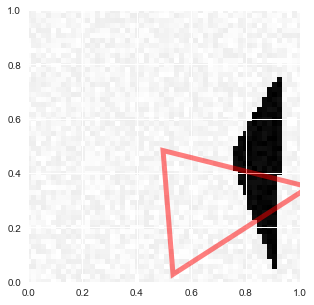

In [245]:
visualize_prediction(X_test[4], model.predict(X_test)[4])

In [246]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 103us/step


[0.10862744450569153, 0.21]

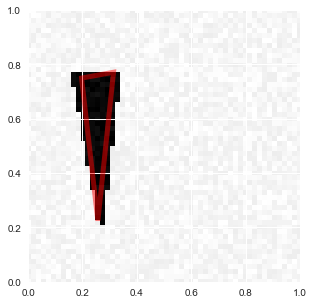

In [247]:
visualize_prediction(X_train[4], model.predict(X_train)[4])

<div class="alert alert-info"><b>The model is overfitting on training data.</b>


<b>Let's see what changes when normalizing and using CNN.</b>




<b>we propose to sort the vertices according to the value of their x-axis coordinate.
    
    
vertices=[x1,y1,x2,y2,x3,y3] in arbitrary order </b>
</div>

In [354]:
def sort_vertices(Y):
    Yr = Y.reshape(-1, 3, 2)
    Yc = Yr.copy()
    Sorted_indexes = np.argsort(Y[:, ::2], axis=1)
    for i, j in enumerate(Sorted_indexes):
        Yc[i, :] = Yc[i,j]
    
    return Yc.reshape(-1, 6)

In [355]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)
[X_test, Y_test] = generate_test_set_regression()
X_train=X_train.reshape(X_train.shape[0],72,72,1)
X_train=X_train.astype('float32')
X_test=X_test.reshape(X_test.shape[0],72,72,1)
X_test=X_test.astype('float32')
Y_train=sort_triangles(Y_train)
Y_test=sort_triangles(Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [360]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=5, activation='relu', input_shape=(72, 72, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6))
model.compile(loss='mse', optimizer=Adam(lr=1e-3, beta_1=0.7, beta_2=0.999, epsilon=1e-08),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 15, 15, 64)        8256      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 3136)              0         
__________

In [362]:
model.fit(X_train,Y_train,epochs=30,batch_size=128)

Epoch 1/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0376 - acc: 0.5690
Epoch 2/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0272 - acc: 0.6357
Epoch 3/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0218 - acc: 0.6827
Epoch 4/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0167 - acc: 0.7363
Epoch 5/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0145 - acc: 0.7477
Epoch 6/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0137 - acc: 0.7613
Epoch 7/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0124 - acc: 0.7780
Epoch 8/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0124 - acc: 0.7950
Epoch 9/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0092 - acc: 0.8070
Epoch 10/30
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0080 - acc: 0.8220
Epoch 11/30
3000/30

In [363]:
model.evaluate(X_test,Y_test)

300/300 [==============================] - 1s 4ms/step


[0.006509388064344724, 0.8666666666666667]

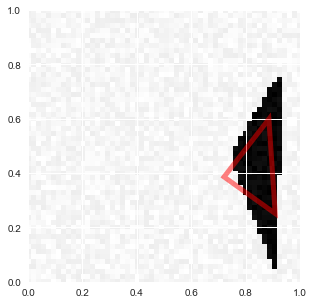

In [364]:
visualize_prediction(X_test[4], model.predict(X_test)[4])

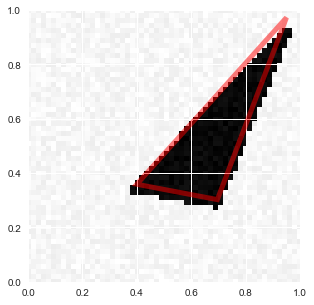

In [365]:
visualize_prediction(X_test[0], model.predict(X_test)[0])

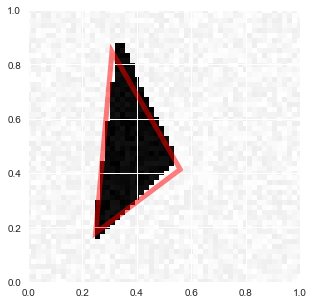

In [366]:
visualize_prediction(X_test[2], model.predict(X_test)[2])

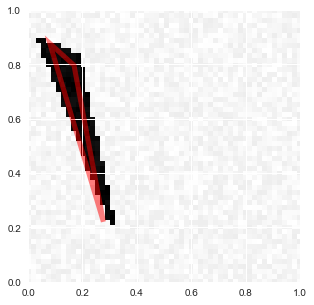

In [367]:
visualize_prediction(X_train[4], model.predict(X_train)[4])

<div class="alert alert-info">
<b>With 3000 training samples </b>

<b>> 87% accuracy and 0.003 loss for training data.</b>
      
<b>86.6% accuracy and 0.006 loss for the generated test data.

</b>


As we can see on the previous figure, the neural network is able to roughly determine the coordinates of the corners of the triangles. We actually help it by reordering the output (Y_train) by increasing x. If we didn't do that the neural network couldn't guess which corner we want to recover the position 
</div>

# Image Denoising

In [14]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noisy = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata_noisy

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_denoising(nb_samples, noise_lim=[20, 40], free_location=True):
    # Getting im_size:
    _, im = generate_a_rectangle()
    im_size = im.shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noisy = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        noise = np.random.uniform(*noise_lim)
        category = np.random.randint(3)
        if category == 0:
            X[i], X_noisy[i] = generate_a_rectangle(noise, free_location=True)
        elif category == 1:
            X[i], X_noisy[i] = generate_a_disk(noise, free_location)
        else:
            [(X[i], X_noisy[i]), _] = generate_a_triangle(noise, free_location)
    X_noisy = (X_noisy + noise) / (255 + 2 * noise)
    X /= 255
    return [X, X_noisy]

In [15]:
[X_train_clean, X_train_noisy] = generate_dataset_denoising(3000)
X_train_clean = X_train_clean.reshape(X_train_clean.shape[0], 72, 72, 1)
X_train_noisy = X_train_noisy.reshape(X_train_noisy.shape[0], 72, 72, 1)
[X_test_clean, X_test_noisy] = generate_dataset_denoising(300)
X_test_clean = X_test_clean.reshape(X_test_clean.shape[0], 72, 72, 1)
X_test_noisy = X_test_noisy.reshape(X_test_noisy.shape[0], 72, 72, 1)

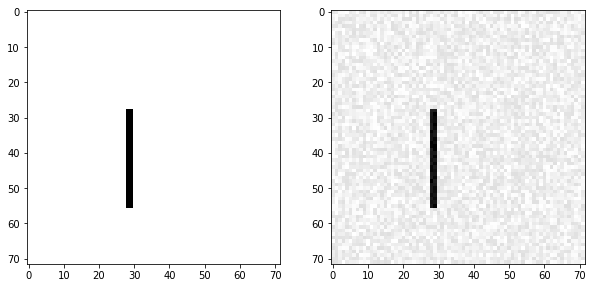

In [16]:
fig = plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(X_train_clean[6].reshape(72,72), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_train_noisy[6].reshape(72,72), cmap='gray')
plt.show()

In [35]:
# Define Model
model=Sequential()
model.add(Conv2D(16,kernel_size=3,strides=2,padding='same',input_shape=(72,72,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(128))
model.add(Dense(512))
model.add(Dense(5184))
model.add(Reshape((9,9,64)))
model.add(Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(32,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(16,kernel_size=3,strides=2,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2DTranspose(1,kernel_size=3,activation='relu',padding='same'))
model.add(Activation('sigmoid'))
model.summary()
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 36, 36, 16)        160       
_________________________________________________________________
batch_normalization_46 (Batc (None, 36, 36, 16)        64        
_________________________________________________________________
activation_50 (Activation)   (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 18, 18, 32)        4640      
_________________________________________________________________
batch_normalization_47 (Batc (None, 18, 18, 32)        128       
_________________________________________________________________
activation_51 (Activation)   (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 9, 9, 64)          18496     
__________

In [21]:
# Compile
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
# Train 
model.fit(X_train_noisy, X_train_clean,batch_size=128,epochs=20)

Epoch 1/20
3000/3000 [==============================] - 123s 41ms/step - loss: 0.0983 - acc: 0.8566
Epoch 2/20
3000/3000 [==============================] - 119s 40ms/step - loss: 0.0396 - acc: 0.9667
Epoch 3/20
3000/3000 [==============================] - 117s 39ms/step - loss: 0.0332 - acc: 0.9764
Epoch 4/20
3000/3000 [==============================] - 115s 38ms/step - loss: 0.0307 - acc: 0.9811
Epoch 5/20
3000/3000 [==============================] - 122s 41ms/step - loss: 0.0292 - acc: 0.9842
Epoch 6/20
3000/3000 [==============================] - 117s 39ms/step - loss: 0.0282 - acc: 0.9864
Epoch 7/20
3000/3000 [==============================] - 117s 39ms/step - loss: 0.0276 - acc: 0.9875
Epoch 8/20
3000/3000 [==============================] - 117s 39ms/step - loss: 0.0272 - acc: 0.9884
Epoch 9/20
3000/3000 [==============================] - 120s 40ms/step - loss: 0.0266 - acc: 0.9898
Epoch 10/20
3000/3000 [==============================] - 118s 39ms/step - loss: 0.0264 - acc: 0.9904

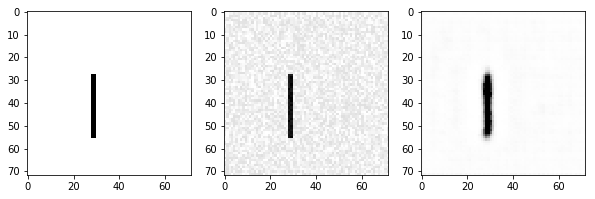

In [22]:
fig = plt.figure(figsize = (10,8))
plt.subplot(1,3,1)
plt.imshow(X_train_clean[6].reshape(72,72), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(X_train_noisy[6].reshape(72,72), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(model.predict(X_train_noisy)[6].reshape(72,72), cmap='gray')
plt.show()

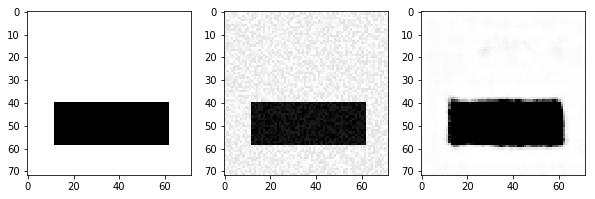

In [23]:
fig = plt.figure(figsize = (10,8))
plt.subplot(1,3,1)
plt.imshow(X_train_clean[5].reshape(72,72), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(X_train_noisy[5].reshape(72,72), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(model.predict(X_train_noisy)[5].reshape(72,72), cmap='gray')
plt.show()

<div class="alert alert-info">
The model is working but it struggles at reconstructing the borders.
</div>